<a href="https://colab.research.google.com/github/UsaMasa/Python/blob/master/PatternRecognitionWithRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNNを用いた粒子軌跡再構成の試み

## 概要
Recuurent Neural Networkを構築し、粒子軌跡のパターン認識可能性を考察する。

### 入力データ
入力形式は以下の構成からなる。

*   event id　：　イベントの番号
*   cluster id　：　クラスターのインデックス
*   layer ：　検出レイヤ番号
*   iphi : 曲座標系における、φのbin番号
*   x : 二次元座標系における、x座標
*   y　：　　二次元座標系における、y座標

これらの情報を使って、2D表示されたATLAS検出器イベントモニタにおける、粒子軌跡分類を行い、その性能を評価したい。


### 素粒子物理学における軌跡パターン認識
素粒子実験では、目に見えない素粒子を捉えるために検出器を用いる。すなわち、粒子が検出器を通過したときに検出器と相互作用して落とすエネルギーを検出することで、間接的に粒子を観測するのである。

検出器を通して得られる情報をつなぎ合わせると、粒子がどのような運動をしたかを示すパラメータ（運動量や位置など）の情報を再構成することができる。これを軌跡の再構成と呼ぶ。

軌跡を再構成するにあたって重要なのが、その前段階のパターン認識である。近年の素粒子実験では大統計の要請から非常に高いビームレートを要求することが多い。この時、着目する粒子以外の粒子の検出情報を誤って使ってパラメータを推定すると、実際とは異なる軌跡を再構成してしまう。そのため、軌跡を再構成するには軌跡のパターン認識、すなわち、1イベント内で検出されたヒットの情報を精度良く、粒子ごとに分類するアルゴリズムが重要になる。



### クラシックな手法：Local Following
素粒子実験のパターン認識において良く成功している手法の一つがLocal Followingと呼ばれる手法である。これは軌跡の起点（Seed）を何らかの手法で確定させ、Kalman Filterなどの再帰アルゴリズムを用いて最良推定状態を更新しながら軌跡を伸ばしていく手法である。

このアルゴリズムの特徴として、数学的に最良推定を再起的に繰り返してパターン認識を行っているので非常に高い精度が出る一方、組み合わせ数が増えると計算時間が増大することが知られている。

### 機械学習的な手法：RNN
RNN（再帰型ニューラルネットワーク）は自然言語処理の分野で良く用いられるネットワークである。連続した情報を扱うのに優れているという特徴は、素粒子実験の検出器の情報を扱うのにも使えるのではないかと考えられる。

### 参考等
* Competitionはこちら: https://ramp.studio/problems/HEP_tracking

* また、このノートの元となるノートブックはこちら: https://github.com/yandexdataschool/mlhep2019/blob/master/notebooks/day-5/tracking/RNN_practice.ipynb

* アイデアや理論に関してはMLHEP day5の講義を参考：https://indico.cern.ch/event/768915/overview


## 実装

In [1]:
! wget https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/metrics.py

--2019-11-25 16:58:55--  https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374 [text/plain]
Saving to: ‘metrics.py’

metrics.py          100%[===================>]     374  --.-KB/s    in 0s      

2019-11-25 16:58:55 (27.1 MB/s) - ‘metrics.py’ saved [374/374]



In [2]:
! wget https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/user_test_submission.py

--2019-11-25 16:59:00--  https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/user_test_submission.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6143 (6.0K) [text/plain]
Saving to: ‘user_test_submission.py’

user_test_submissio 100%[===================>]   6.00K  --.-KB/s    in 0s      

2019-11-25 16:59:00 (68.1 MB/s) - ‘user_test_submission.py’ saved [6143/6143]



In [3]:
! wget https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/public_train.csv

--2019-11-25 16:59:05--  https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/public_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18420554 (18M) [text/plain]
Saving to: ‘public_train.csv’

public_train.csv    100%[===================>]  17.57M  83.4MB/s    in 0.2s    

2019-11-25 16:59:06 (83.4 MB/s) - ‘public_train.csv’ saved [18420554/18420554]



### データの準備

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import user_test_submission as submission
import numpy as np
import math
from metrics import predictor
from sklearn.base import BaseEstimator

In [5]:
!sudo pip install sklearn==0.18.1

ERROR: Could not find a version that satisfies the requirement sklearn==0.18.1 (from versions: 0.0)
ERROR: No matching distribution found for sklearn==0.18.1


In [6]:
data = pandas.read_csv('public_train.csv', index_col=False)
data.head()

,event_id,cluster_id,layer,iphi,x,y
0,3,4,4,53253,53.900430,-265.585662
1,3,1,5,37216,-47.614439,-402.191329
2,3,1,0,7181,-4.253919,-38.767308
3,3,3,2,7937,44.418132,148.499258
4,3,4,0,7657,7.588600,-38.254583


In [7]:
X = data.drop(['cluster_id'], axis=1).values # XにクラスターIDを落としたものをコピーする
y = data[['event_id', 'cluster_id']].values
print(y.shape)

(418059, 2)


In [8]:
# イベントID(0列目の全ての要素)
event_ids = X[:, 0]

# 重複を許さないイベントIDの行列を準備する
unique_event_ids = np.unique(event_ids)

i_event = unique_event_ids[0] # event id の0番目を例えば取ってくる
X_event = X[event_ids == i_event]
y_event = y[event_ids == i_event]
print(i_event)
print(y_event.shape)

3.0
(55, 2)


### 可視化

In [0]:
def plot_event(X, y=None, is_plot=True):
    
    cmap = ['k', 'b', 'y', 'g', 'r', 'k']
    R=[39, 85, 155, 213, 271, 405, 562, 762, 1000]
    
    hit_x = X[:, 3]#Xの3列目、すなわちx
    hit_y = X[:, 4]#Xの4列目、すなわちy
    
    plt.figure(figsize=(6, 6))
    
    if y is None: # event idを指定しなければ、全てをプロットする
        plt.scatter(hit_x, hit_y)       
    if y is not None: # event idを指定すれば、そのイベントをプロットする
        for i_track in np.unique(y): #yの中から重複を全て無くして一次元の配列にする（ここでは全てのcluster idを洗い出している）
            track_mask = y == i_track # y == i_trackのhit_x, hit_yを抜き出すための条件式。このindex を指定する
            track_x = hit_x[track_mask]
            track_y = hit_y[track_mask]
            track_r = np.sqrt(track_x**2 + track_y**2)
            sorted_ids = np.argsort(track_r)
            if is_plot:
                plt.plot(track_x[sorted_ids], track_y[sorted_ids], color=cmap[int(i_track) % len(cmap)])
            plt.scatter(track_x[sorted_ids], track_y[sorted_ids], color=cmap[int(i_track) % len(cmap)])
        
    for ar in R:
        circle=plt.Circle((0,0), ar, color='0.5', fill=False) # (0,0)を中心とした、半径Rの円
        plt.gcf().gca().add_artist(circle)
    
    plt.xlim(-1100, 1100)
    plt.ylim(-1100, 1100)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.xlabel('X', size=12)
    plt.ylabel('Y', size=12)
    plt.show()

与えられたデータがこれで:


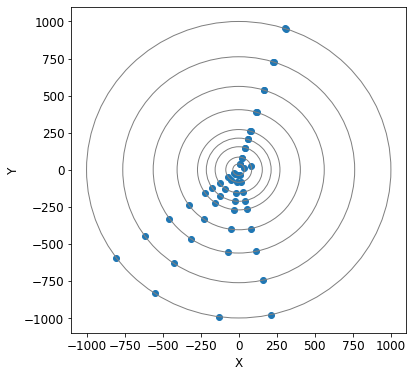

最終的な目的がこのクラシフィケーション:


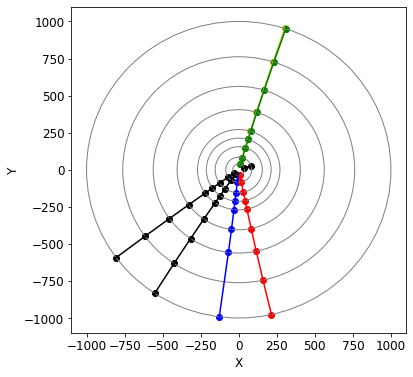

In [10]:
print("与えられたデータがこれで:")
plot_event(X_event, None)

print("最終的な目的がこのクラシフィケーション:")
plot_event(X_event, y_event[:, 1])

### データの前処理
訓練データとテストデータの切り分けを行う。

In [0]:
from sklearn.model_selection import train_test_split
#sklearnパッケージの切り分け用関数を使う。
event_ids = np.unique(data['event_id'].values)
event_ids_train, event_ids_test = train_test_split(event_ids, 
                                                   test_size=1000, 
                                                   random_state=42)

X_train, y_train = X[data['event_id'].isin(event_ids_train)], y[data['event_id'].isin(event_ids_train)]
X_test, y_test   = X[data['event_id'].isin(event_ids_test)],  y[data['event_id'].isin(event_ids_test)]

RNN用のインプットを作る。
そのままでは使えないので、ヒットの情報をクラスターごとのφのbin番号に置き換える。

In [0]:
num_phi_bin = 100

In [0]:
#前処理用の関数
class det_geo():
    layer_r     = np.array([39,    85,    155,   213,   271,   405,  562,  762,  1000])
    layer_pitch = np.array([0.025, 0.025, 0.025, 0.025, 0.025, 0.05, 0.05, 0.05, 0.05])#layer内のpixel-pitch。内側は密に、外側は粗く。
    num_layers = layer_r.shape[0]
    #iphiという変数は、phiをレイヤーピッチで割ったもの（すなわち、何番目のピクセルか）で表されている
    max_phi = (2 * np.pi * layer_r / layer_pitch + 1).astype(np.int)
    
def rescale_phi(phi, nbin, layer):
    return (phi * float(nbin) / det_geo.max_phi[layer.astype(np.int)]).astype(np.int)
#φの値をmax_φの値で割ったものにbin数をかけることでスケールし直す。この場合は最大でも100になる。

#訓練用のインプット、アウトプットとなるヒットを作成する関数
def event_hits_transform(X, y=None, num_phi_bin=100):
    
    evids, layers, phis = X[:,0].astype(np.int), X[:,1].astype(np.int), X[:,2].astype(np.int)
    phis = rescale_phi(phis, num_phi_bin, layers)
    
    # 0番目のレイヤーでのヒットのインデックスを取得する（これがシードヒット）
    seed_idx = np.where(layers == 0)[0]
    num_seeds = seed_idx.size
    
    #　訓練用のインプットは残りのイベントから続くシードヒットを含む
    train_input = np.zeros((num_seeds, det_geo.num_layers, num_phi_bin))
    # 訓練用の目標は信号軌跡の個別の画像である
    train_target = np.zeros_like(train_input)#train_inputと同じ形状の0行列を生成する　

    # 全てのシードに関するループ
    for i_sample in range(num_seeds):
        # i_sample番目のヒットのインデックスをihitとする
        i_hit = seed_idx[i_sample]

        # 訓練用のインプットの最初のレイヤに、シードヒットを入れる（hit = 1）
        # 最外層だけは、シードヒットしか無いことに注意する
        train_input[i_sample, 0, phis[i_hit]] = 1
        # 他の層を、残りのヒットで埋める。ここには全てのヒットを入れる。
        train_input[i_sample, layers[layers > 0], phis[layers > 0]] = 1

        # この軌跡（シード）由来のヒットを埋める。yは正解ラベル。
        if y is not None:
            track_ids = y[:, 1] # cluster idの取得
            seed_track_id = y[i_hit, 1] # ihit番目のcluster idの取得
            train_target[i_sample, layers[track_ids == seed_track_id], phis[track_ids == seed_track_id]] = 1
            # i_sampleのシードについて、track_id (cluster id)の一致するヒットのみを目標の正解ラベルに入れる
    return train_input, train_target

In [0]:
#視覚化用の関数
def plot_event_polar(X):
    
    plt.figure(figsize=(6, 6))
    
    plt.pcolor(X.T)
    
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    plt.xlabel('Layer bins', size=12)
    plt.ylabel('Phi bins', size=12)
    
    plt.show()

### 1イベント処理

In [15]:
# データの前処理
# 1 event分のデータ (X_event, y_event) をまず変換してみて感覚を掴む。
# X_event, y_eventを変換する。X_event_polarがtrain_input、y_event_polarがtrain_targetに相当
X_event_polar, y_event_polar = event_hits_transform(X_event, y_event, num_phi_bin)
# Display shapes
print(X_event.shape)
print(y_event.shape)
X_event_polar.shape, y_event_polar.shape
print(X_event_polar[0,1,:])
#サイズは、（i_amples(ここではクラスターの0番目)、レイヤー数、ファイのビン数）

(55, 5)
(55, 2)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


前処理をする前のイベントモニタ:


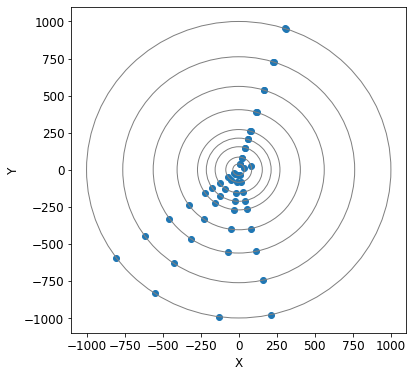

RNNの入力として与えるイベントモニタ:


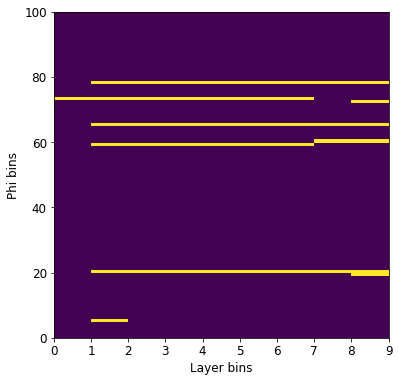

RNNからの出力（1track）:


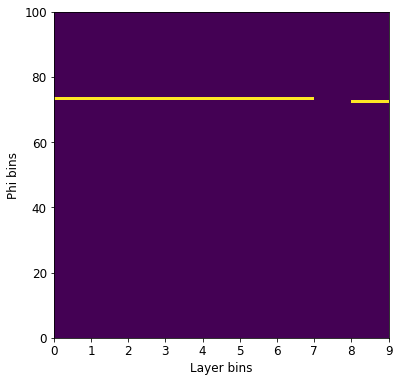

In [16]:
i_train = 0

print("前処理をする前のイベントモニタ:")
plot_event(X_event, None)
print("RNNの入力として与えるイベントモニタ:")
plot_event_polar(X_event_polar[i_train])
print("RNNからの出力（1track）:")
plot_event_polar(y_event_polar[i_train])

### 全イベントの前処理を行う

In [0]:
train_input = []
train_target = []

event_ids = X_train[:, 0]
for i_event in np.unique(event_ids):
    
    # やることは1event処理と同じ。event loopを回して全イベントを変換する。
    X_ev = X_train[event_ids == i_event]
    y_ev = y_train[event_ids == i_event]
    train_input_ev, train_target_ev = event_hits_transform(X_ev, y_ev, num_phi_bin)
    train_input.append(train_input_ev)
    train_target.append(train_target_ev)

X_train_polar = np.concatenate(tuple(train_input))
y_train_polar = np.concatenate(tuple(train_target))

In [18]:
# Display shapes
X_train_polar.shape, y_train_polar.shape

((38565, 9, 100), (38565, 9, 100))

## RNNモデルの定義
LSTM modelを採用する。

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm_notebook

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.lstm1 = nn.LSTM(100, 150, batch_first=True)
        self.dense1 = nn.Linear(150, 100)
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(p=0.2)
 
    def forward(self, x):
        
        hid_sequence, (c_last, h_last) = self.lstm1(x)
        hid_sequence = self.dropout(self.dense1(hid_sequence))
        logits = self.softmax(hid_sequence)
        return logits

In [0]:
class MyClassifier(object):
    
    def __init__(self, model, n_epochs=10, batch_size=64):
     
        self.model = model
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        
    
    def fit(self, X, y):
          
        # X, yをtorch tensorへ変換する
        X_tensor = torch.as_tensor(X, dtype=torch.float32, device=device)
        y_tensor = torch.as_tensor(y, dtype=torch.float32, device=device)
        
        #訓練用のデータセットを作る
        train_data = TensorDataset(X_tensor, y_tensor)
       
        opt = torch.optim.Adam(self.model.parameters())
        self.model.train(True)
        
        # 訓練を行う
        for epoch_i in range(self.n_epochs):
            loss_history = []
            for x_batch, y_batch in tqdm_notebook(DataLoader(train_data, batch_size=self.batch_size, shuffle=True)):
               
                logits = self.model(x_batch)
            
                loss = -(torch.log(logits) * y_batch).sum(-1).mean()
                opt.zero_grad()
                loss.backward()
                opt.step()
                loss_history.append(loss.item())
            print("epoch: %i, mean loss: %.5f" % (epoch_i, np.mean(loss_history)))
    
    def predict(self, X):# numpy 
        
        self.model.train(False)       
        X_tensor = torch.as_tensor(X, dtype=torch.float32, device=device)
        y_pred = model(X_tensor)
        print(y_pred.shape)
        return y_pred.cpu().detach().numpy()

In [21]:
# モデルの生成とフィット
model=Model().to(device=device)
clf = MyClassifier(model=model, n_epochs=50, batch_size=64)
clf.fit(X_train_polar, y_train_polar)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



epoch: 0, mean loss: 2.87320



epoch: 1, mean loss: 1.83889



epoch: 2, mean loss: 1.52933



epoch: 3, mean loss: 1.36545



epoch: 4, mean loss: 1.25558



epoch: 5, mean loss: 1.19504



epoch: 6, mean loss: 1.15858



epoch: 7, mean loss: 1.12991



epoch: 8, mean loss: 1.11224



epoch: 9, mean loss: 1.10380



epoch: 10, mean loss: 1.08447



epoch: 11, mean loss: 1.07971



epoch: 12, mean loss: 1.06604



epoch: 13, mean loss: 1.07318



epoch: 14, mean loss: 1.06043



epoch: 15, mean loss: 1.05747



epoch: 16, mean loss: 1.05986



epoch: 17, mean loss: 1.05387



epoch: 18, mean loss: 1.05118



epoch: 19, mean loss: 1.04696



epoch: 20, mean loss: 1.04442



epoch: 21, mean loss: 1.04328



epoch: 22, mean loss: 1.04291



epoch: 23, mean loss: 1.04044



epoch: 24, mean loss: 1.03495



epoch: 25, mean loss: 1.03477



epoch: 26, mean loss: 1.03725



epoch: 27, mean loss: 1.03243



epoch: 28, mean loss: 1.03526



epoch: 29, mean loss: 1.02715



epoch: 30, mean loss: 1.02923



epoch: 31, mean loss: 1.02591



epoch: 32, mean loss: 1.02434



epoch: 33, mean loss: 1.02404



epoch: 34, mean loss: 1.02299



epoch: 35, mean loss: 1.02101



epoch: 36, mean loss: 1.02190



epoch: 37, mean loss: 1.01291



epoch: 38, mean loss: 1.02166



epoch: 39, mean loss: 1.02195



epoch: 40, mean loss: 1.01704



epoch: 41, mean loss: 1.01809



epoch: 42, mean loss: 1.01333



epoch: 43, mean loss: 1.01768



epoch: 44, mean loss: 1.01248



epoch: 45, mean loss: 1.01886



epoch: 46, mean loss: 1.01699



epoch: 47, mean loss: 1.01451



epoch: 48, mean loss: 1.01932



epoch: 49, mean loss: 1.01314


In [22]:
# 1イベントに対する予測を行う。
y_event_polar_pred = clf.predict(X_event_polar)
print(y_event_polar_pred.shape)
print(X_event_polar.shape)

torch.Size([7, 9, 100])
(7, 9, 100)
(7, 9, 100)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


RNN output for the track:


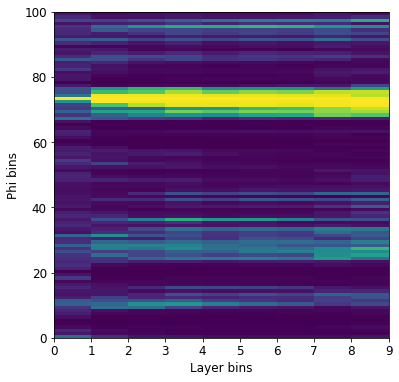

True output for the track:


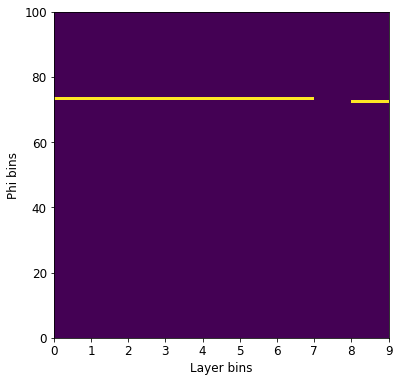

In [24]:
i_train = 0

print("RNN output for the track:")
plot_event_polar(y_event_polar_pred[i_train])

print("True output for the track:")
plot_event_polar(y_event_polar[i_train])

## 軌跡のパターン認識の試み

In [0]:
class Clusterer(object):

    def __init__(self, classifier=None):

        self.classifier = classifier
    
    def fit(self, X, y):
        pass

    
    def predict_single_event(self, X):

        trkid = np.zeros(X.shape[0])
        for i in range(trkid.shape[0]):
            
            lays, phis = X[:,1].astype(np.int), X[:,2].astype(np.int)
            phis = rescale_phi(phis, num_phi_bin, lays)
            lay, phi = lays[i], phis[i]
            #基本は1eventの時と同じ。
            X_polar, _ = event_hits_transform(X, None, num_phi_bin)
            # 　入力に対する予測を受け取る
            y_polar_pred = clf.predict(X_polar)

            # seedの数だけの大きさの配列。このスコアの要素は、今見ているヒットがどのシードに属するかの確率を表す。
            scores = y_polar_pred[:, lays[i], phis[i]]
            # 最もスコアの高いものを答え（クラスターID）とする
            best = np.argmax(scores)
            trkid[i] = best
            
        return trkid

In [26]:
ctr = Clusterer(classifier=clf)

y_event_pred = ctr.predict_single_event(X_event)
y_event_pred # bestなスコアのtrack id

torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9, 100])
torch.Size([7, 9

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([1., 0., 0., 3., 1., 3., 3., 3., 3., 5., 3., 0., 2., 3., 2., 5., 3.,
       3., 4., 1., 3., 2., 3., 5., 3., 1., 2., 2., 0., 2., 0., 2., 3., 5.,
       2., 1., 5., 1., 5., 3., 5., 1., 0., 3., 3., 0., 1., 1., 4., 5., 0.,
       3., 3., 5., 2.])

Recognized tracks:


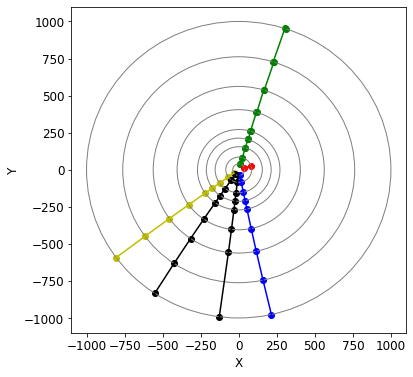

In [27]:
print("Recognized tracks:")
plot_event(X_event, y_event_pred, is_plot=True)

In [0]:
%%time
from metrics import predictor
y_pred_test = predictor(ctr, X_test, y_test)

In [29]:
score = submission.score_function(y_test, y_pred_test)
print("Score: {:1.4f}".format(score))

Score: 0.8871
